# Dataset Split Generator — Step 5

**Goal:**  
Create *patient-disjoint* training and validation splits for the processed dataset,  
ensuring no data leakage and maintaining approximately an 80/20 balance by **patch count**.

---

### What this notebook does
1. Loads patch metadata from the processed dataset.  
2. Computes how many patches belong to each patient.  
3. Selects train/val patients to achieve ~80/20 patch ratio.  
4. Saves train/val split files (`train.csv`, `val.csv`) under `/splits`.  
5. Prints balance and sanity checks.


### Table of Contents
- [Step 1 — Load paths and patch metadata](#step1)
- [Step 2 — Patch Extraction and Label Generation](#step2)
- [Step 3 — Visual Inspection of Generated Patches](#step3)
- [Step 4 — Summary and Quality Checks](#step4)
- [Step 5 — Dataset Integrity + Overview](#step5)

<a id="step1"></a>
## Step 1 — Load paths and patch metadata

In [3]:
from pathlib import Path
import pandas as pd

# --- Configuration ---
DATASET_DIR = Path("/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512")
LABELS_DIR = DATASET_DIR / "labels"
SPLITS_DIR = DATASET_DIR / "splits"
SPLITS_DIR.mkdir(exist_ok=True)

# --- Gather patch info ---
patch_paths = sorted(LABELS_DIR.glob("*.csv"))
records = []

for f in patch_paths:
    stem = f.stem
    # Extract patient ID (before first underscore)
    patient_id = stem.split("_")[0]
    records.append({"patient": patient_id, "patch": stem})

df = pd.DataFrame(records)
print(f"Total patches found: {len(df)}")
print(f"Unique patients: {df['patient'].nunique()}")
display(df.head())


Total patches found: 200
Unique patients: 49


,patient,patch
0,TCGA-55-1594-01Z-00-DX1,TCGA-55-1594-01Z-00-DX1_001_0_0
1,TCGA-55-1594-01Z-00-DX1,TCGA-55-1594-01Z-00-DX1_001_0_512
2,TCGA-55-1594-01Z-00-DX1,TCGA-55-1594-01Z-00-DX1_001_512_0
3,TCGA-55-1594-01Z-00-DX1,TCGA-55-1594-01Z-00-DX1_001_512_512
4,TCGA-55-1594-01Z-00-DX1,TCGA-55-1594-01Z-00-DX1_002_0_0


<a id="step2"></a>
## Step 2 — Compute per-patient patch counts

Total patches: 200
Patch count per patient:


patient
TCGA-B9-A8YI-01Z-00-DX1      12
TCGA-S3-AA11-01Z-00-DX1      12
TCGA-D8-A1X5-01Z-00-DX2      11
TCGA-E9-A22B-01Z-00-DX1      10
TCGA-EJ-5517-01Z-00-DX1-4     9
TCGA-69-A59K-01Z-00-DX1       9
TCGA-86-8672-01Z-00-DX1       8
TCGA-55-1594-01Z-00-DX1       8
TCGA-B6-A0WZ-01Z-00-DX1       7
TCGA-78-7220-01Z-00-DX1       7
TCGA-69-7760-01Z-00-DX1       7
TCGA-BH-A18T-01Z-00-DX1       6
TCGA-P4-AAVK-01Z-00-DX1       6
TCGA-MH-A560-01Z-00-DX2       6
TCGA-EJ-5495-01Z-00-DX1-1     6
TCGA-5P-A9K0-01Z-00-DX1       5
TCGA-73-4668-01Z-00-DX1       5
TCGA-MP-A4SY-01Z-00-DX1       5
TCGA-YL-A9WY-01Z-00-DX1-1     4
TCGA-86-7713-01Z-00-DX1       4
TCGA-G9-6499-01Z-00-DX1-4     4
TCGA-B9-A44B-01Z-00-DX1       4
TCGA-F9-A97G-01Z-00-DX1       3
TCGA-EW-A6SD-01Z-00-DX1       3
TCGA-A2-A0CV-01Z-00-DX1       3
TCGA-A2-A0ES-01Z-00-DX1       3
TCGA-E9-A22G-01Z-00-DX1       3
TCGA-EV-5903-01Z-00-DX1       2
TCGA-KK-A6E0-01Z-00-DX1-2     2
TCGA-DW-7841-01Z-00-DX1       2
TCGA-E2-A154-01Z-00-DX1       2


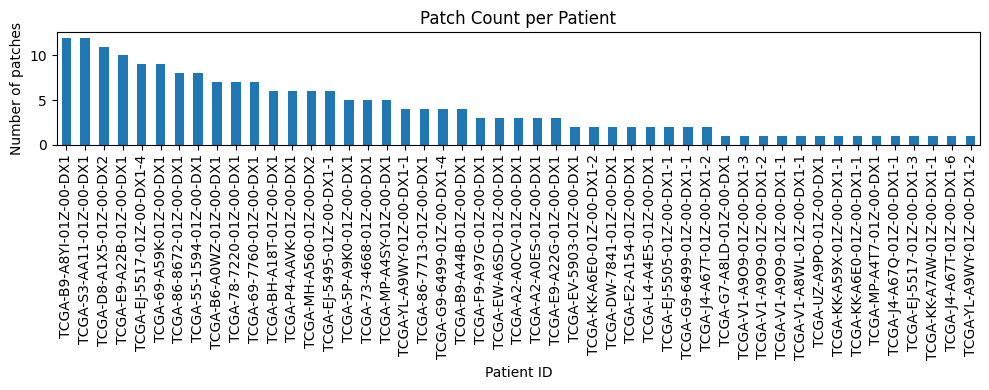

In [4]:
patient_patch_counts = df.groupby("patient").size().sort_values(ascending=False)
total_patches = patient_patch_counts.sum()

print(f"Total patches: {total_patches}")
print("Patch count per patient:")
display(patient_patch_counts)

# Visualize distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
patient_patch_counts.plot(kind="bar")
plt.title("Patch Count per Patient")
plt.xlabel("Patient ID")
plt.ylabel("Number of patches")
plt.tight_layout()
plt.show()


<a id="step3"></a>
## Step 3 — Patient-level 80/20 patch-balanced split

In [5]:
# Greedy accumulation by patch count until ~80% total
target_train = 0.8 * total_patches
cumulative = 0
train_patients = []

for patient, count in patient_patch_counts.items():
    if cumulative < target_train:
        train_patients.append(patient)
        cumulative += count
    else:
        break

val_patients = [p for p in patient_patch_counts.index if p not in train_patients]

train_ratio = cumulative / total_patches
val_ratio = 1 - train_ratio

print(f"Train patients: {len(train_patients)} | Validation patients: {len(val_patients)}")
print(f"Approx patch ratio → Train: {train_ratio:.1%}, Val: {val_ratio:.1%}")


Train patients: 24 | Validation patients: 25
Approx patch ratio → Train: 80.5%, Val: 19.5%


<a id="step4"></a>
## Step 4 — Save train/val patch lists

In [8]:
train_patches = df[df["patient"].isin(train_patients)]["patch"]
val_patches   = df[df["patient"].isin(val_patients)]["patch"]

train_patches.to_csv(SPLITS_DIR / "train.csv", index=False, header=False)
val_patches.to_csv(SPLITS_DIR / "val.csv", index=False, header=False)

print(f"Saved train.csv ({len(train_patches)} patches) and val.csv ({len(val_patches)} patches) under {SPLITS_DIR}")


Saved train.csv (161 patches) and val.csv (39 patches) under /projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512/splits


<a id="step5"></a>
## Step 5 — Verify patch and class balance


Patch distribution summary:
Train patches: 161 (80.5%)
Val patches:   39 (19.5%)


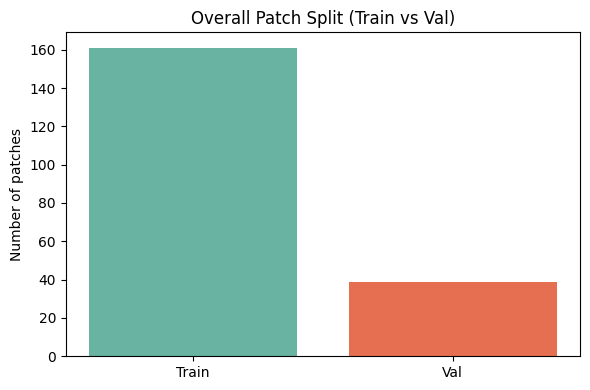

In [7]:
# Quick counts
train_counts = df[df["patient"].isin(train_patients)]["patient"].value_counts()
val_counts   = df[df["patient"].isin(val_patients)]["patient"].value_counts()

print("\nPatch distribution summary:")
print(f"Train patches: {len(train_patches)} ({train_ratio:.1%})")
print(f"Val patches:   {len(val_patches)} ({val_ratio:.1%})")

plt.figure(figsize=(6,4))
plt.bar(["Train", "Val"], [len(train_patches), len(val_patches)], color=["#69b3a2", "#e76f51"])
plt.ylabel("Number of patches")
plt.title("Overall Patch Split (Train vs Val)")
plt.tight_layout()
plt.show()
